In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm 
#from xgboost import XGBClassifier
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, LSTM, Dense, Dropout, Flatten

print("Finished Importing")

Finished Importing


In [2]:
bns = h5py.File('comb1_bns.hdf5','r')
nsb = h5py.File('comb5_nsbh.hdf5','r')

eos = 'APR4'
band = 'mAB_R'

In [3]:
# Data preprocessing - making sure that each of the files has a 0 or 1 corresponding 
# to whether or not we have a bns or a nsbh or not.

bns_eos_band = bns[eos][band] # shape -> (7522, 400), (len(bns_eos_band), len(bns[eos][band][0]))
nsb_eos_band = nsb[eos][band] # shape -> (439, 400)

bns_label = np.zeros(len(bns_eos_band))
nsb_label = np.ones(len(nsb_eos_band))

time_band = bns[eos]['time'] # shape -> (400, )

all_data = np.concatenate([bns_eos_band, nsb_eos_band], axis=0)
all_labels = np.concatenate([bns_label, nsb_label], axis=0)

all_data_with_time = np.stack([all_data, np.tile(time_band, (all_data.shape[0], 1))], axis=1)  # Shape -> (7961, 2, 400)

print_structure = True

# Creating the dataset
with h5py.File('light_curves_with_time.hdf5', 'w') as f:
    # Dataset for light curve data, including time as the second "band"
    f.create_dataset('light_curves', data=all_data_with_time, compression="gzip", compression_opts=9)
    
    # Dataset for labels
    f.create_dataset('labels', data=all_labels, compression="gzip", compression_opts=9)
    
    # Store the time array separately as metadata if it's constant for all samples
    # f.create_dataset('time', data=time_band, compression="gzip", compression_opts=9)
    
    # Add metadata
    f.attrs['description'] = "Light curve data for BNS and NSBH mergers, with time included"
    f.attrs['bands'] = ["mAB_band", "time"]
    f.attrs['time_steps'] = 400
    f.attrs['BNS_class'] = 0  # BNS class label
    f.attrs['NSBH_class'] = 1  # NSBH class label

    f.close()

def print_structure(name, obj):
    # Prints the name and type of each item in the HDF5 file
    print(f"{name}: {type(obj)}")
    if isinstance(obj, h5py.Dataset):  # If it's a dataset, print shape and dtype
        print(f"  - Shape: {obj.shape}")
        print(f"  - Data type: {obj.dtype}")
    elif isinstance(obj, h5py.Group):  # If it's a group, list the contents
        print(f"  - Contains: {list(obj.keys())}")

with h5py.File('light_curves_with_time.hdf5', 'r') as f:
    print("File Structure:")
    f.visititems(print_structure)
    
    # Print file-level attributes
    print("\nFile Attributes:")
    for key, value in f.attrs.items():
        print(f"  {key}: {value}")

    f.close()

print("Finished pre-processing the data")

File Structure:
labels: <class 'h5py._hl.dataset.Dataset'>
  - Shape: (7961,)
  - Data type: float64
light_curves: <class 'h5py._hl.dataset.Dataset'>
  - Shape: (7961, 2, 400)
  - Data type: float64

File Attributes:
  BNS_class: 0
  NSBH_class: 1
  bands: ['mAB_band' 'time']
  description: Light curve data for BNS and NSBH mergers, with time included
  time_steps: 400
Finished pre-processing the data


In [4]:
# Data preprocessing - making sure that each of the files has a 0 or 1 corresponding 
# to whether or not we have a bns or a nsbh or not.

bns_eos_band = bns[eos][band] # shape -> (7522, 400), (len(bns_eos_band), len(bns[eos][band][0]))
nsb_eos_band = nsb[eos][band] # shape -> (439, 400)

bns_label = np.zeros(len(bns_eos_band))
nsb_label = np.ones(len(nsb_eos_band))

all_data = np.concatenate([bns_eos_band, nsb_eos_band], axis=0)
all_labels = np.concatenate([bns_label, nsb_label], axis=0)

print_structure = True

# Creating the dataset
with h5py.File('light_curves_without_time.hdf5', 'w') as f:
    # Dataset for light curve data, including time as the second "band"
    f.create_dataset('light_curves', data=all_data, compression="gzip", compression_opts=9)
    
    # Dataset for labels
    f.create_dataset('labels', data=all_labels, compression="gzip", compression_opts=9)
    
    # Add metadata
    f.attrs['description'] = "Light curve data for BNS and NSBH mergers, without time"
    f.attrs['bands'] = ["mAB_band"]
    f.attrs['BNS_class'] = 0  # BNS class label
    f.attrs['NSBH_class'] = 1  # NSBH class label

    f.close()
    

def print_structure(name, obj):
    # Prints the name and type of each item in the HDF5 file
    print(f"{name}: {type(obj)}")
    if isinstance(obj, h5py.Dataset):  # If it's a dataset, print shape and dtype
        print(f"  - Shape: {obj.shape}")
        print(f"  - Data type: {obj.dtype}")
    elif isinstance(obj, h5py.Group):  # If it's a group, list the contents
        print(f"  - Contains: {list(obj.keys())}")

with h5py.File('light_curves_without_time.hdf5', 'r') as f:
    print("File Structure:")
    f.visititems(print_structure)
    
    # Print file-level attributes
    print("\nFile Attributes:")
    for key, value in f.attrs.items():
        print(f"  {key}: {value}")

    f.close()

print("Finished pre-processing the data")

File Structure:
labels: <class 'h5py._hl.dataset.Dataset'>
  - Shape: (7961,)
  - Data type: float64
light_curves: <class 'h5py._hl.dataset.Dataset'>
  - Shape: (7961, 400)
  - Data type: float64

File Attributes:
  BNS_class: 0
  NSBH_class: 1
  bands: ['mAB_band']
  description: Light curve data for BNS and NSBH mergers, without time
Finished pre-processing the data


Display the equation of states:

bns.keys()

Corresponding to each equation of state you have a bunch of light curves

- LC = bolometric
- mAB ones are the ones that we "observe" and the ones that you care about. mAB is a unit.
- mBH1 should actually mNS1

bns['APR4'].keys() -> Shows the different light curves for a given equation of state.


Plots a particular band for a given eos: 

for i in tqdm(range(len(bns[eos][band]))):
    plt.plot(bns[eos]['time'][:]/(24*3600),bns[eos][band][i][:],alpha=0.1,c='r')
    
plt.gca().invert_yaxis()
plt.show()

#### Approach

1. Fix EOS and fix band (do for all bands).
2. Relax the EOS assumption and fix band.
3. In general, start with `r` and `u` bands.
4. End result- Feed one light curve in a particular band and it should tell me that the system is BNS or NSBH with X%, (100-X)% of confidence.

100%|████████████████████████████████████████████████| 7961/7961 [01:00<00:00, 131.24it/s]


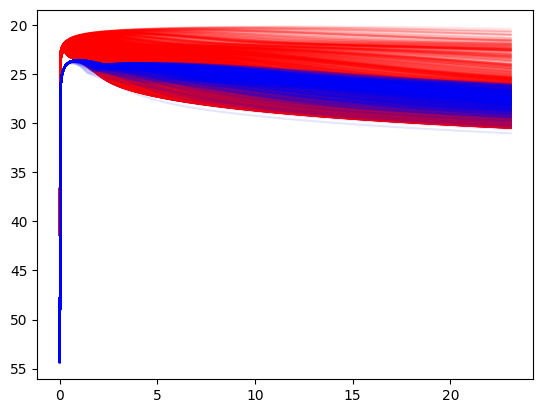

In [4]:
eos_band_time_file = 'light_curves_with_time.hdf5'
eos_band_time_training_file = h5py.File(eos_band_time_file,'r')
print_data = True
show_data = True
i = 7000

if print_data == True:
    with h5py.File(eos_band_time_file, 'r') as f:
        # Access the light curves dataset and labels
        light_curves = f['light_curves']
        labels = f['labels']
        
        # Retrieve the i-th sample's brightness and time values
        brightness_values = light_curves[i]  # The brightness values (1st channel)
        #time_values = light_curves[i, 1]        # The time values (2nd channel)
        label = labels[i]                          # The label for this sample (0 or 1)

        #print(f"Brightness values for sample {i}:", brightness_values)
        #print(f"Time values for sample {i}:", time_values)
        #print(f"Label for sample {i} (0 for BNS, 1 for NSBH):", label)

        f.close()

if show_data == True:
    for i in tqdm(range(len(eos_band_time_training_file['light_curves']))):
        c="r"
        if eos_band_time_training_file['labels'][i] == 1:
            c="b"
        plt.plot(eos_band_time_training_file['light_curves'][i, 1, :][:] / (24*3600), 
                eos_band_time_training_file['light_curves'][i, 0, :][:], alpha=0.1, c=c)
    

    plt.gca().invert_yaxis()
    plt.show()


In [8]:
eos_band_time_file = 'light_curves_without_time.hdf5'

with h5py.File(eos_band_time_file, 'r') as f:
    light_curves = f['light_curves'][:]  # Shape: (7961, 2, 400)
    labels = f['labels'][:]              # Shape: (7961,)

    f.close()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(light_curves, labels, test_size=0.2, random_state=42)

# Resample so that we have an even number of values
X_train_combined = X_train.reshape(X_train.shape[0], -1)
y_train_combined = y_train

X_train_class_0 = X_train_combined[y_train_combined == 0]
X_train_class_1 = X_train_combined[y_train_combined == 1]

X_class_1_oversampled = resample(X_train_class_1, replace=True, n_samples=len(X_train_class_0), random_state=42)
y_class_1_oversampled = np.ones(len(X_class_1_oversampled))

X_balanced = np.vstack((X_train_class_0, X_class_1_oversampled))
y_balanced = np.hstack((np.zeros(len(X_train_class_0)), y_class_1_oversampled))

X_balanced = X_balanced.reshape(-1, 2, 400)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the model
model = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=42)
model.fit(X_train_flat, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test_flat)
print(classification_report(y_test, y_pred, target_names=["Class 0 (BNS)", "Class 1 (NSBH)"]))

                precision    recall  f1-score   support

 Class 0 (BNS)       1.00      1.00      1.00      1508
Class 1 (NSBH)       1.00      1.00      1.00        85

      accuracy                           1.00      1593
     macro avg       1.00      1.00      1.00      1593
  weighted avg       1.00      1.00      1.00      1593



In [10]:
eos_band_time_file = 'light_curves_without_time.hdf5'

with h5py.File(eos_band_time_file, 'r') as f:
    light_curves = f['light_curves'][:]  # Shape: (7961, 2, 400)
    labels = f['labels'][:]              # Shape: (7961,)

    f.close()

# light_curves[i, 0] gives the ith sample's brighness values in mAB, and light_curves[i, 1] gives the ith sample's time steps
# each of them should have 400 values.

# scaler = StandardScaler()

# # Reshape data to 2D for scaling
# n_samples, n_timesteps, n_features = light_curves.shape
# light_curves_2d = light_curves.reshape(-1, n_features)
# light_curves_2d = scaler.fit_transform(light_curves_2d)

# # Reshape back to 3D
# light_curves = light_curves_2d.reshape(n_samples, n_timesteps, n_features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(light_curves, labels, test_size=0.2, random_state=42)

# Resample so that we have an even number of values
X_train_combined = X_train.reshape(X_train.shape[0], -1)
y_train_combined = y_train

X_train_class_0 = X_train_combined[y_train_combined == 0]
X_train_class_1 = X_train_combined[y_train_combined == 1]

X_class_1_oversampled = resample(X_train_class_1, replace=True, n_samples=len(X_train_class_0), random_state=42)
y_class_1_oversampled = np.ones(len(X_class_1_oversampled))

X_balanced = np.vstack((X_train_class_0, X_class_1_oversampled))
y_balanced = np.hstack((np.zeros(len(X_train_class_0)), y_class_1_oversampled))

X_balanced = X_balanced.reshape(-1, 400, 1)
X_test = X_test.reshape(-1, 400, 1) 

#print("X_balanced and y", X_balanced[800, 1], y_balanced[800])

# Define the model with an Input layer
model = Sequential([
    Input(shape=(400, 1)),             # Define input shape here
    LSTM(64, return_sequences=True),   # First LSTM layer
    Dropout(0.3),
    LSTM(32, return_sequences=False),  # Second LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),      # Dense layer for further processing
    Dropout(0.3),
    Dense(1, activation='sigmoid')     # Output layer for binary classification
])

# model = Sequential([
#     Flatten(input_shape=(2, 400)),             # Define input shape here
#     Dense(64, activation='relu'),   # First LSTM layer
#     Dropout(0.3),
#     Dense(32, activation='relu'),  # Second LSTM layer
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')     # Output layer for binary classification
# ])

# X_balanced = X_balanced.transpose((0, 2, 1))  # Transpose from (samples, 2, 400) to (samples, 400, 2)
# X_test = X_test.transpose((0, 2, 1))

# model = Sequential([
#     Conv1D(64, kernel_size=3, activation='relu', input_shape=(400, 2)),
#     MaxPooling1D(pool_size=2),
#     Conv1D(32, kernel_size=3, activation='relu'),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

print("Finished Summary")

# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(enumerate(class_weights))

# Fit the model on the training data
history = model.fit(X_balanced, y_balanced, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

print("Finished fitting the model")

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Assuming `X_test` is the test set we want to make predictions on
predictions = model.predict(X_test)

# Show the raw output (probabilities) for the first 5 samples
print("Raw predictions:", predictions[:5])

# # Convert probabilities to binary class labels
# # Threshold of 0.5: anything >= 0.5 is class 1 (NSBH), anything < 0.5 is class 0 (BNS)
# predicted_classes = (predictions >= 0.5).astype(int)

# # Show the predicted class labels for the first 5 samples
# print("Predicted classes:", predicted_classes[:5])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 400, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

Finished Summary
Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 60s 193ms/step - accuracy: 0.6062 - loss: 0.6728 - val_accuracy: 0.0000e+00 - val_loss: 1.0382
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.6217 - loss: 0.6604 - val_accuracy: 0.0000e+00 - val_loss: 0.8451
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.6220 - loss: 0.6469 - val_accuracy: 0.0000e+00 - val_loss: 1.0897
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.6375 - loss: 0.6412 - val_accuracy: 0.0000e+00 - val_loss: 0.9174
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.6407 - loss: 0.6366 - val_accuracy: 0.0000e+00 - val_loss: 0.9145
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - accuracy: 0.6237 - loss: 0.6478 - val_accuracy: 0.0000e+00 - val_loss: 1.0023
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.6119 - loss: 0.6634 - val_accuracy: 0.0000e+00 - val_loss: 0.9116
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None